## Objective:

To empirically model the temporary market impact function gt(x) which measures the per-share slippage when executing an order of size 𝑥 at time 𝑡. We aim to determine which function better describes this impact, using data from three tickers.


In [3]:
# Import required libraries
import os
from pathlib import Path

data_dir = Path("data")
pkl_dir = data_dir / "pkl"
extracted_dir = data_dir / "extracted"

In [48]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pickle
import numpy as np
import statsmodels.api as sm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


## Data Extraction

We are provided with three zip files (CRWV.zip, FROG.zip, and SOUN.zip) containing limit order book data.

In [5]:
# Extract each zip file into a subfolder under 'extracted/'
# To be run only once initially

# List of file provided
files = ["CRWV", "FROG", "SOUN"]

for file in files:
    zip_path = os.path.join(data_dir, f"{file}.zip")
    target_folder = os.path.join(extracted_dir, file)
    os.makedirs(target_folder, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_folder)

    print(f"Extracted {file} data to {target_folder}")

Extracted CRWV data to data\extracted\CRWV
Extracted FROG data to data\extracted\FROG
Extracted SOUN data to data\extracted\SOUN


In [6]:
def load_file_data(file):
    """
    Loads all CSV files for a given file from the extracted folder,
    and returns a combined DataFrame.
    """
    folder_path = os.path.join(extracted_dir, file)
    csv_files = sorted(glob.glob(os.path.join(folder_path, "*.csv")))
    
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found for {file} in {folder_path}")
    
    dataframes = [pd.read_csv(file) for file in csv_files]
    combined_df = pd.concat(dataframes, ignore_index=True)
    
    print(f"Loaded {len(combined_df)} rows for {file}")
    return combined_df

frog_df = load_file_data("FROG")
crwv_df = load_file_data("CRWV")
soun_df = load_file_data("SOUN")

frog_df.head()

Loaded 589053 rows for FROG
Loaded 1882484 rows for CRWV
Loaded 5505097 rows for SOUN


,ts_event,ts_event.1,rtype,publisher_id,instrument_id,action,side,depth,price,size,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2025-04-03 13:30:00.125395235+00:00,2025-04-03 13:30:00.125395235+00:00,10,2,6292,C,B,4,29.70,100,...,4,1,1,28.49,33.92,100,100,1,1,FROG
1,2025-04-03 13:30:00.125739764+00:00,2025-04-03 13:30:00.125739764+00:00,10,2,6292,A,A,3,32.79,100,...,800,1,1,28.49,33.85,100,4,1,1,FROG
2,2025-04-03 13:30:00.125745044+00:00,2025-04-03 13:30:00.125745044+00:00,10,2,6292,A,B,4,29.74,100,...,800,1,1,28.96,33.85,800,4,1,1,FROG
3,2025-04-03 13:30:00.170027597+00:00,2025-04-03 13:30:00.170027597+00:00,10,2,6292,A,B,3,29.89,100,...,800,1,1,28.97,33.85,100,4,1,1,FROG
4,2025-04-03 13:30:00.404726961+00:00,2025-04-03 13:30:00.404726961+00:00,10,2,6292,A,B,7,29.13,100,...,800,1,1,29.00,33.85,20,4,1,1,FROG


In [7]:
def subsample_orderbook_snapshots(df, timestamp_col="ts_event"):
    """
    Subsamples to the first full order book snapshot per minute.
    Assumes each row contains full top-10 levels of bid/ask.
    """
    # Convert timestamp column to datetime
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format='mixed')
    
    # Floor timestamps to the nearest minute (using 'min' instead of deprecated 'T')
    df['minute'] = df[timestamp_col].dt.floor('min')
    
    # Keep only the first snapshot per minute
    snapshot_df = df.groupby('minute').first().reset_index()
    
    print(f"Subsampled {df} to {len(snapshot_df)} rows (one per minute)")
    return snapshot_df

In [8]:
frog_1min = subsample_orderbook_snapshots(frog_df)
crwv_1min = subsample_orderbook_snapshots(crwv_df)
soun_1min = subsample_orderbook_snapshots(soun_df)
frog_1min.head()

Subsampled                                   ts_event  \
0      2025-04-03 13:30:00.125395235+00:00   
1      2025-04-03 13:30:00.125739764+00:00   
2      2025-04-03 13:30:00.125745044+00:00   
3      2025-04-03 13:30:00.170027597+00:00   
4      2025-04-03 13:30:00.404726961+00:00   
...                                    ...   
589048 2025-05-02 19:59:59.781629196+00:00   
589049 2025-05-02 19:59:59.954081520+00:00   
589050 2025-05-02 19:59:59.954088009+00:00   
589051 2025-05-02 19:59:59.974039117+00:00   
589052 2025-05-02 19:59:59.974047879+00:00   

                                 ts_event.1  rtype  publisher_id  \
0       2025-04-03 13:30:00.125395235+00:00     10             2   
1       2025-04-03 13:30:00.125739764+00:00     10             2   
2       2025-04-03 13:30:00.125745044+00:00     10             2   
3       2025-04-03 13:30:00.170027597+00:00     10             2   
4       2025-04-03 13:30:00.404726961+00:00     10             2   
...                         

,minute,ts_event,ts_event.1,rtype,publisher_id,instrument_id,action,side,depth,price,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,symbol
0,2025-04-03 13:30:00+00:00,2025-04-03 13:30:00.125395235+00:00,2025-04-03 13:30:00.125395235+00:00,10,2,6292,C,B,4,29.70,...,4,1,1,28.49,33.92,100,100,1,1,FROG
1,2025-04-03 13:31:00+00:00,2025-04-03 13:31:01.010568274+00:00,2025-04-03 13:31:01.010568274+00:00,10,2,6292,A,A,4,31.98,...,200,2,2,30.48,32.27,10,100,1,1,FROG
2,2025-04-03 13:32:00+00:00,2025-04-03 13:32:26.830824360+00:00,2025-04-03 13:32:26.830824360+00:00,10,2,6292,T,N,0,31.64,...,100,1,1,30.83,32.65,104,100,2,1,FROG
3,2025-04-03 13:33:00+00:00,2025-04-03 13:33:01.596946627+00:00,2025-04-03 13:33:01.596946627+00:00,10,2,6292,A,A,3,32.21,...,130,1,2,30.83,32.51,104,100,2,1,FROG
4,2025-04-03 13:34:00+00:00,2025-04-03 13:34:45.706010957+00:00,2025-04-03 13:34:45.706010957+00:00,10,2,6292,C,B,0,31.41,...,100,1,1,30.83,32.65,104,100,2,1,FROG


In [23]:
frog_1min.to_pickle(pkl_dir/'frog_1min.pkl')
crwv_1min.to_pickle(pkl_dir/'crwv_1min.pkl')
soun_1min.to_pickle(pkl_dir/'soun_1min.pkl')

## Data Loading and Exlporation

In [24]:
frog_1min = pd.read_pickle(pkl_dir/'frog_1min.pkl')
crwv_1min = pd.read_pickle(pkl_dir/'crwv_1min.pkl')
soun_1min = pd.read_pickle(pkl_dir/'crwv_1min.pkl')

In [25]:
# Summary stats for numerical features
print("FROG numerical summary:")
display(frog_1min.describe())

print("CRWV numerical summary:")
display(crwv_1min.describe())

print("SOUN numerical summary:")
display(soun_1min.describe())

FROG numerical summary:


,rtype,publisher_id,instrument_id,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,mid_price
count,8162.0,8162.0,8162.0,8162.000000,8162.000000,8162.000000,8162.000000,8.162000e+03,8.162000e+03,8162.000000,...,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000,8162.000000
mean,10.0,2.0,6292.0,1.500368,31.604438,76.376501,124.723107,1.686387e+05,5.838778e+08,31.555159,...,196.218941,1.548763,1.546067,31.245872,31.988712,199.804337,207.850772,1.477089,1.532590,31.606857
std,0.0,0.0,0.0,2.195798,1.843080,118.870668,25.121648,3.387659e+04,4.180867e+08,1.844303,...,243.960176,0.776689,0.786728,1.851868,1.814796,249.378023,242.471079,0.731444,0.772952,1.836963
min,10.0,2.0,6292.0,0.000000,26.930000,1.000000,0.000000,1.656130e+05,1.626442e+07,27.020000,...,1.000000,1.000000,1.000000,25.570000,27.470000,1.000000,1.000000,1.000000,1.000000,27.130000
25%,10.0,2.0,6292.0,0.000000,30.230000,5.000000,130.000000,1.662490e+05,3.048192e+08,30.170000,...,100.000000,1.000000,1.000000,29.890000,30.730000,100.000000,100.000000,1.000000,1.000000,30.230000
50%,10.0,2.0,6292.0,0.000000,31.630000,35.000000,130.000000,1.665280e+05,4.798131e+08,31.560000,...,104.000000,1.000000,1.000000,31.190000,31.965000,104.000000,104.000000,1.000000,1.000000,31.620000
75%,10.0,2.0,6292.0,2.000000,33.160000,100.000000,130.000000,1.673290e+05,7.245255e+08,33.150000,...,201.000000,2.000000,2.000000,32.760000,33.450000,201.750000,210.000000,2.000000,2.000000,33.180000
max,10.0,2.0,6292.0,9.000000,36.310000,2817.000000,130.000000,2.446870e+06,2.341308e+09,35.540000,...,9515.000000,12.000000,7.000000,35.450000,37.750000,6604.000000,4600.000000,10.000000,7.000000,35.565000


CRWV numerical summary:


,rtype,publisher_id,instrument_id,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,mid_price
count,8190.0,8190.0,8190.0,8190.000000,8190.000000,8190.000000,8190.000000,8.190000e+03,8.190000e+03,8190.000000,...,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000
mean,10.0,2.0,14993.0,0.541880,8.450375,547.137973,127.515507,1.692234e+05,5.826395e+08,8.443928,...,2808.204762,7.521490,6.607082,8.353806,8.544665,2591.080098,2715.038217,7.538339,6.409402,8.449229
std,0.0,0.0,0.0,1.320769,0.827705,8004.880561,16.340727,2.732898e+04,4.180482e+08,0.827173,...,5093.114418,9.702723,10.324185,0.827180,0.826957,6677.690004,5630.054757,11.727497,9.766203,0.827083
min,10.0,2.0,14993.0,0.000000,6.440000,1.000000,0.000000,1.653820e+05,1.623591e+07,6.550000,...,1.000000,1.000000,1.000000,6.460000,6.650000,1.000000,2.000000,1.000000,1.000000,6.555000
25%,10.0,2.0,14993.0,0.000000,7.820000,49.000000,130.000000,1.662220e+05,3.035761e+08,7.810000,...,1000.000000,4.000000,4.000000,7.720000,7.910000,800.000000,805.000000,3.000000,3.000000,7.815000
50%,10.0,2.0,14993.0,0.000000,8.250000,100.000000,130.000000,1.667405e+05,4.792019e+08,8.250000,...,1600.000000,5.000000,5.000000,8.160000,8.350000,1405.000000,1410.000000,5.000000,5.000000,8.255000
75%,10.0,2.0,14993.0,0.000000,9.350000,240.000000,130.000000,1.688030e+05,7.238539e+08,9.340000,...,2782.750000,8.000000,7.000000,9.250000,9.440000,2318.750000,2493.000000,7.000000,7.000000,9.345000
max,10.0,2.0,14993.0,9.000000,10.000000,709602.000000,130.000000,2.543657e+06,2.341294e+09,9.950000,...,120305.000000,236.000000,230.000000,9.860000,10.050000,196291.000000,120305.000000,161.000000,227.000000,9.955000


SOUN numerical summary:


,rtype,publisher_id,instrument_id,depth,price,size,flags,ts_in_delta,sequence,bid_px_00,...,ask_sz_08,bid_ct_08,ask_ct_08,bid_px_09,ask_px_09,bid_sz_09,ask_sz_09,bid_ct_09,ask_ct_09,mid_price
count,8190.0,8190.0,8190.0,8190.000000,8190.000000,8190.000000,8190.000000,8.190000e+03,8.190000e+03,8190.000000,...,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000,8190.000000
mean,10.0,2.0,14993.0,0.541880,8.450375,547.137973,127.515507,1.692234e+05,5.826395e+08,8.443928,...,2808.204762,7.521490,6.607082,8.353806,8.544665,2591.080098,2715.038217,7.538339,6.409402,8.449229
std,0.0,0.0,0.0,1.320769,0.827705,8004.880561,16.340727,2.732898e+04,4.180482e+08,0.827173,...,5093.114418,9.702723,10.324185,0.827180,0.826957,6677.690004,5630.054757,11.727497,9.766203,0.827083
min,10.0,2.0,14993.0,0.000000,6.440000,1.000000,0.000000,1.653820e+05,1.623591e+07,6.550000,...,1.000000,1.000000,1.000000,6.460000,6.650000,1.000000,2.000000,1.000000,1.000000,6.555000
25%,10.0,2.0,14993.0,0.000000,7.820000,49.000000,130.000000,1.662220e+05,3.035761e+08,7.810000,...,1000.000000,4.000000,4.000000,7.720000,7.910000,800.000000,805.000000,3.000000,3.000000,7.815000
50%,10.0,2.0,14993.0,0.000000,8.250000,100.000000,130.000000,1.667405e+05,4.792019e+08,8.250000,...,1600.000000,5.000000,5.000000,8.160000,8.350000,1405.000000,1410.000000,5.000000,5.000000,8.255000
75%,10.0,2.0,14993.0,0.000000,9.350000,240.000000,130.000000,1.688030e+05,7.238539e+08,9.340000,...,2782.750000,8.000000,7.000000,9.250000,9.440000,2318.750000,2493.000000,7.000000,7.000000,9.345000
max,10.0,2.0,14993.0,9.000000,10.000000,709602.000000,130.000000,2.543657e+06,2.341294e+09,9.950000,...,120305.000000,236.000000,230.000000,9.860000,10.050000,196291.000000,120305.000000,161.000000,227.000000,9.955000


In [26]:
def plot_price_size_timeseries(df, symbol):
    """
    Plots price distribution, size distribution, and price over time side by side for a given dataframe.
    
    Parameters:
    - df: DataFrame containing columns 'price', 'size', and 'ts_event'
    - symbol: string to label the plots (e.g., 'FROG', 'CRWV', 'SOUN')
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    
    sns.histplot(df['price'], bins=50, kde=True, ax=axes[0])
    axes[0].set_title(f"Price Distribution - {symbol}")
    
    sns.histplot(df['size'], bins=50, kde=True, ax=axes[1])
    axes[1].set_title(f"Size Distribution - {symbol}")
    
    axes[2].plot(df['ts_event'], df['price'], marker='.', linestyle='none', markersize=2)
    axes[2].set_title(f"Price Over Time - {symbol}")
    axes[2].set_xlabel("Timestamp")
    axes[2].set_ylabel("Price")
    
    plt.tight_layout()
    plt.show()

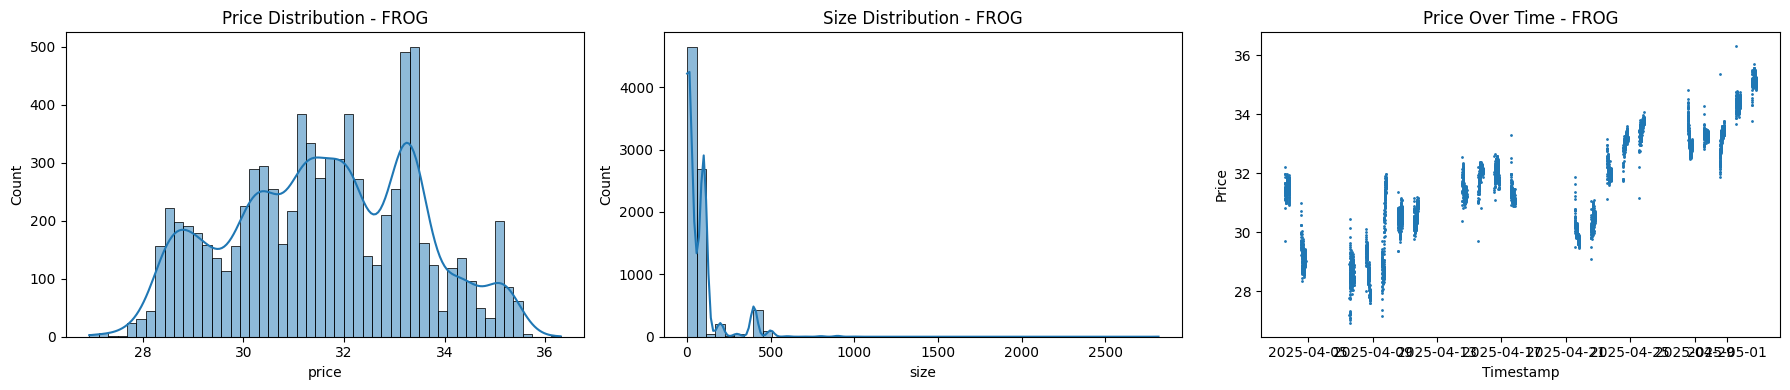

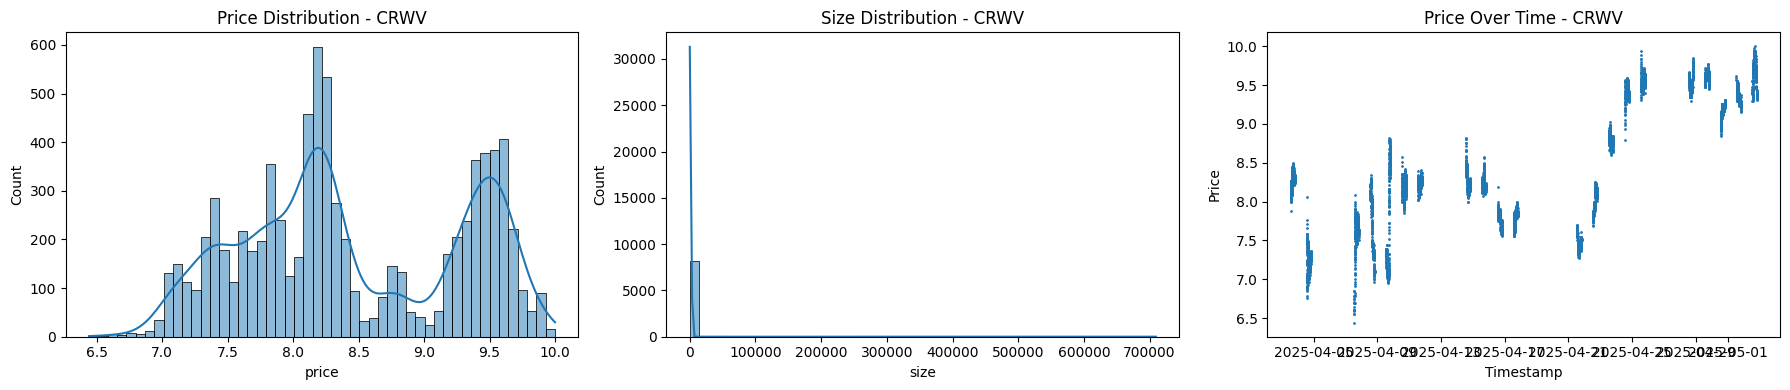

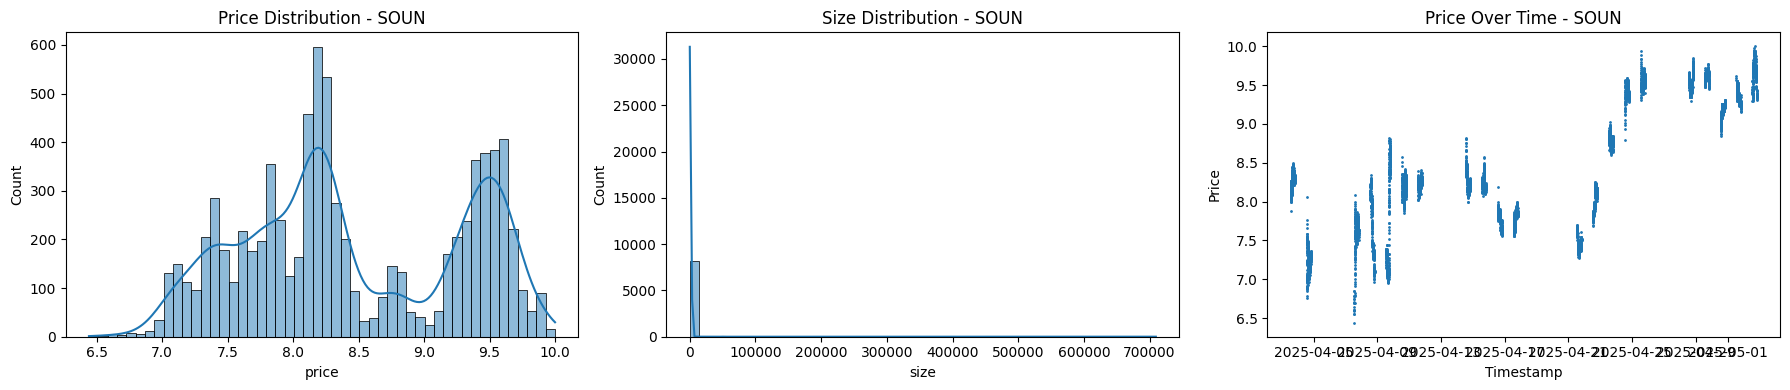

In [27]:
plot_price_size_timeseries(frog_1min, 'FROG')
plot_price_size_timeseries(crwv_1min, 'CRWV')
plot_price_size_timeseries(soun_1min, 'SOUN')

### Mid-Price Computation and Trade Extraction

For each order book snapshot, we compute the mid-price as the mean of the best bid and best ask prices. We identify trade executions (rows where the action column indicates a trade) to measure price impact.

We then calculate the price immediately before the trade and immediately after to quantify the temporary impact.


In [28]:
def prepare_trade_data(df):
    """
    Prepares trade-level data by calculating the mid-price from top bid and ask levels,
    filtering trade events, and computing the immediate price impact as the change
    in mid-price from the previous trade, along with trade size.

    Parameters:
    df (pd.DataFrame): DataFrame containing order book snapshots with bid and ask prices and trade actions.

    Returns:
    pd.DataFrame: Filtered DataFrame of trades including mid-price, pre-trade mid-price,
                  price impact, and trade size.
    """
    df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
    trades_df = df[df['action'] == 'T'].copy()
    trades_df = trades_df.sort_values('ts_event')

    trades_df['pre_trade_mid'] = trades_df['mid_price'].shift(1)
    trades_df['price_impact'] = trades_df['mid_price'] - trades_df['pre_trade_mid']

    # Assuming 'size' column indicates trade size, add trade_size column
    trades_df['trade_size'] = trades_df['size']

    trades_df = trades_df.dropna(subset=['price_impact'])
    return trades_df

In [29]:
frog_trades = prepare_trade_data(frog_1min)
crwv_trades = prepare_trade_data(crwv_1min)
soun_trades = prepare_trade_data(soun_1min)

# frog_trades.head()

In [30]:
def plot_price_impact_vs_size(trades_df, ticker_name):
    """
    Plot the relationship between trade size and immediate price impact for a given ticker.
    
    trades_df: DataFrame containing trade data with columns:
               - 'trade_size': size of the trade
               - 'price_impact': immediate change in mid-price after the trade
    ticker_name: string label for the ticker (e.g., 'FROG')
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    plt.figure(figsize=(8, 5))
    
    # Scatter plot of price impact vs trade size (log scale for better visualization)
    sns.scatterplot(x='trade_size', y='price_impact', data=trades_df, alpha=0.3)
    
    # Optionally, plot binned average price impact to smooth noise
    bins = np.logspace(np.log10(trades_df['trade_size'].min()), np.log10(trades_df['trade_size'].max()), 20)
    trades_df['size_bin'] = pd.cut(trades_df['trade_size'], bins)
    bin_means = trades_df.groupby('size_bin', observed=True)['price_impact'].mean()
    bin_centers = [interval.mid for interval in bin_means.index]
    
    plt.plot(bin_centers, bin_means, color='red', marker='o', linestyle='-', label='Binned Mean')
    
    plt.xscale('log')
    plt.xlabel('Trade Size (log scale)')
    plt.ylabel('Immediate Price Impact')
    plt.title(f'Price Impact vs Trade Size - {ticker_name}')
    plt.legend()
    plt.show()


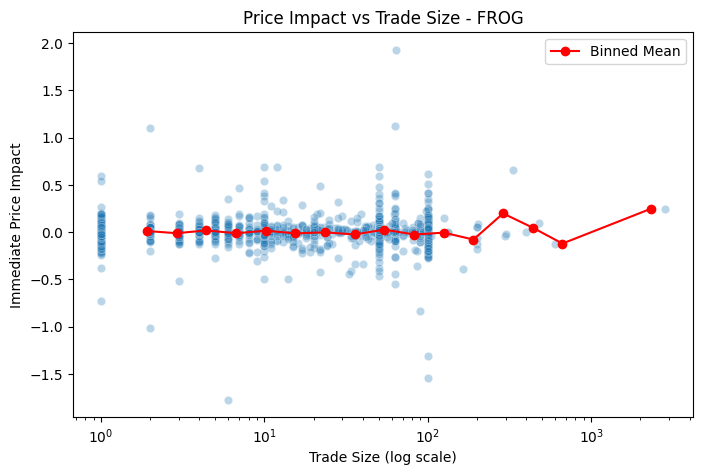

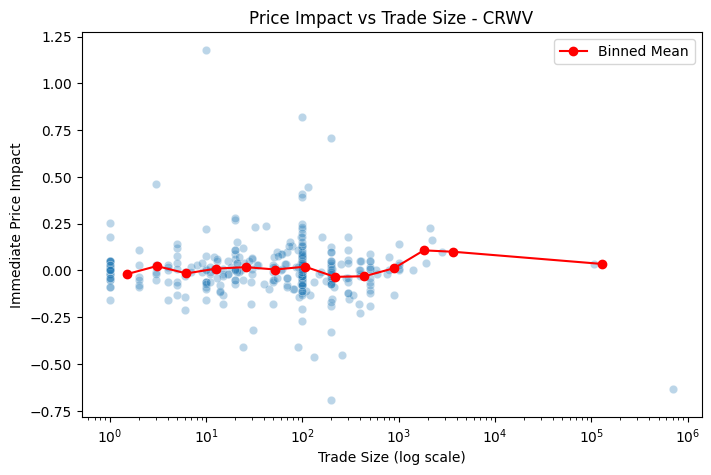

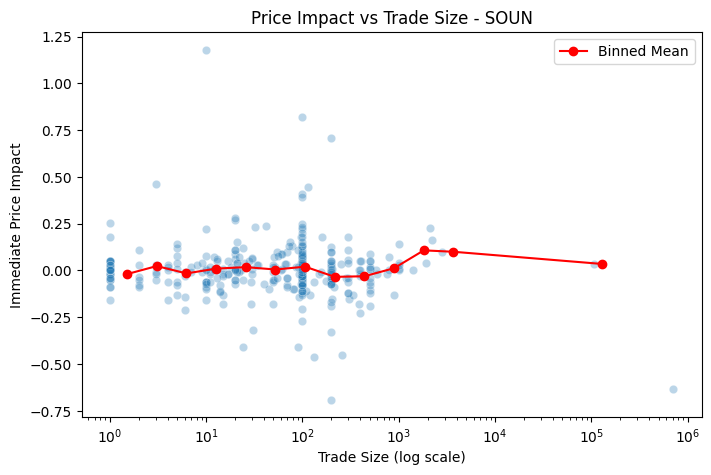

In [31]:
plot_price_impact_vs_size(frog_trades, "FROG")
plot_price_impact_vs_size(crwv_trades, "CRWV")
plot_price_impact_vs_size(soun_trades, "SOUN")

## Linear Model for Temporary Impact

We model the temporary impact g_t(x) as a linear function of trade size x, i.e., g_t(x) \approx \beta_t x. This is a common simplification where the immediate price change caused by a trade is assumed proportional to the trade volume.

To fit this model, we perform a linear regression of the observed price impact (difference between mid-price before and after the trade) on the trade size. We evaluate the fit using the coefficient of determination (R²) and visualize the predicted vs actual impacts to assess the model's adequacy.

Given the limited data (3 tickers) and market complexity, the linear model serves as a baseline before considering more complex functional forms.


In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def fit_temporary_impact_linear_model(trades_df):
    """
    Fits a linear regression model to approximate temporary impact g_t(x) ≈ β_t * x.
    trades_df must contain 'size' (trade size) and 'price_impact' columns.
    Returns the fitted model and R^2 score.
    """
    X = trades_df[['size']].values.reshape(-1, 1)
    y = trades_df['price_impact'].values
    
    model = LinearRegression()
    model.fit(X, y)
    
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    
    print(f"Fitted linear model coefficient (β_t): {model.coef_[0]:.6f}")
    print(f"Intercept: {model.intercept_:.6f}")
    print(f"R² score: {r2:.4f}")
    
    return model, r2

def plot_impact_vs_size(trades_df, model=None):
    """
    Plots the observed price impact vs trade size scatter plot.
    If a linear model is provided, overlays the fitted line.
    """
    plt.figure(figsize=(8, 5))
    plt.scatter(trades_df['size'], trades_df['price_impact'], alpha=0.3, label='Observed')
    
    if model:
        size_range = np.linspace(trades_df['size'].min(), trades_df['size'].max(), 100).reshape(-1, 1)
        predicted_impact = model.predict(size_range)
        plt.plot(size_range, predicted_impact, color='red', label='Linear Fit')
    
    plt.xlabel("Trade Size")
    plt.ylabel("Price Impact")
    plt.title("Price Impact vs Trade Size")
    plt.legend()
    plt.show()

--- FROG ---
Fitted linear model coefficient (β_t): 0.000075
Intercept: 0.000050
R² score: 0.0017


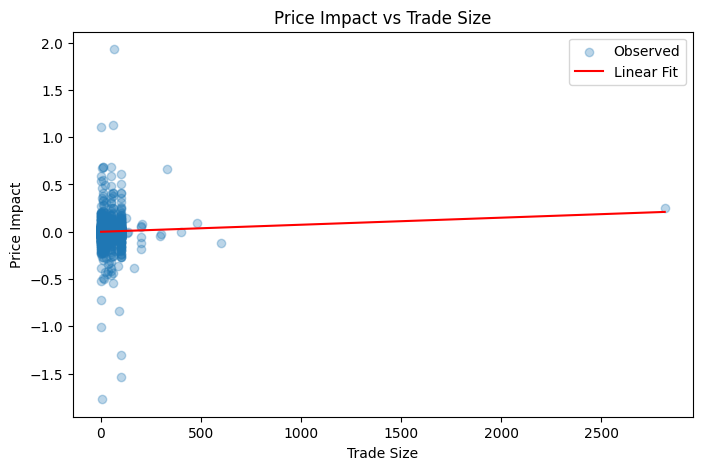

--- CRWV ---
Fitted linear model coefficient (β_t): -0.000001
Intercept: 0.005752
R² score: 0.0511


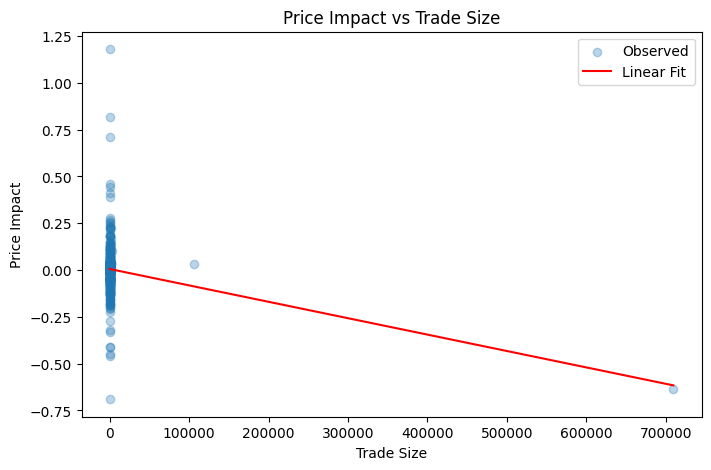

--- SOUN ---
Fitted linear model coefficient (β_t): -0.000001
Intercept: 0.005752
R² score: 0.0511


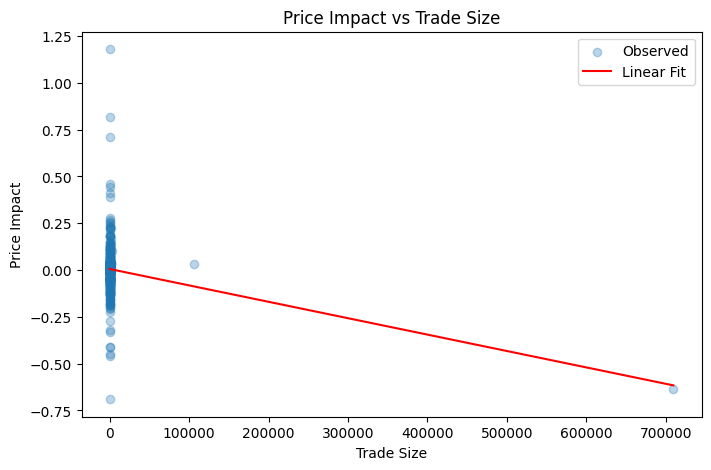

In [33]:
tickers = {
    'FROG': frog_trades,
    'CRWV': crwv_trades,
    'SOUN': soun_trades
}

results = {}

for ticker, df in tickers.items():
    print(f"--- {ticker} ---")
    model, r2 = fit_temporary_impact_linear_model(df)
    plot_impact_vs_size(df, model)
    results[ticker] = {'model': model, 'r2': r2}


**Inference from Linear Model**

The linear models for the three tickers show very low R² scores (FROG: 0.0017, CRWV and SOUN: 0.0511). This means the models do not explain much of the price impact using trade size.

The coefficients 𝛽_𝑡 are very close to zero. This shows there is little or no clear link between trade size and price impact in this data. The intercept values are small but positive, which might mean there is some price impact even when trade size is zero.

These results suggest that a simple linear model is not enough. The relationship between trade size and price impact is likely more complex.

## Nonlinear Model for Temporary Impact

We extend the modeling of temporary impact 𝑔_𝑡(𝑥) using a nonlinear power-law form: 
𝑔_𝑡(𝑥)=𝛽𝑥^𝛼 where 𝛼 captures the curvature and 𝛽 controls the scale of impact.

To estimate the parameters, we log-transform both the impact and trade size, converting the model into a linear form: 
log𝑔_𝑡(𝑥)=log𝛽+𝛼log𝑥
We then fit a linear regression on these transformed variables.

This approach allows for diminishing or accelerating impact with trade size, making it more flexible than a purely linear model. We report the estimated parameters, R² score, and visualize the model's predictions to understand fit quality.

While the power-law model introduces nonlinearity, its performance still appears limited on the available data, highlighting the need to consider richer models or additional market variables.

In [ ]:

def fit_power_law_impact(trades_df):
    """
    Fits a power-law model to trade data to model g_t(x) = β_t * x^α.
    Returns estimated alpha, beta, and regression summary.

    Parameters:
    trades_df (pd.DataFrame): Trade data containing 'trade_size' and 'price_impact'.

    Returns:
    tuple: (alpha, beta, regression_summary)
    """
    filtered = trades_df[trades_df['trade_size'] > 0].copy()
    filtered['abs_size'] = np.abs(filtered['trade_size'])
    filtered['abs_impact'] = np.abs(filtered['price_impact'])

    # Take logs
    filtered['log_size'] = np.log(filtered['abs_size'])
    filtered['log_impact'] = np.log(filtered['abs_impact'] + 1e-10)  # Avoid log(0)

    # Fit linear model to log-log data: log(g_t) = log(beta) + alpha * log(x)
    X = sm.add_constant(filtered['log_size'])
    y = filtered['log_impact']
    model = sm.OLS(y, X).fit()

    alpha = model.params['log_size']
    log_beta = model.params['const']
    beta = np.exp(log_beta)

    return alpha, beta, model.summary()


In [39]:
alpha_frog, beta_frog, summary_frog = fit_power_law_impact(frog_trades)
print("--- FROG Power-Law Model ---")
print(f"Alpha (curvature): {alpha_frog:.5f}")
print(f"Beta (scale): {beta_frog:.8f}")
print(summary_frog)

alpha_crwv, beta_crwv, summary_crwv = fit_power_law_impact(crwv_trades)
print("--- CRWV Power-Law Model ---")
print(f"Alpha (curvature): {alpha_crwv:.5f}")
print(f"Beta (scale): {beta_crwv:.8f}")
print(summary_crwv)

alpha_soun, beta_soun, summary_soun = fit_power_law_impact(soun_trades)
print("--- SOUN Power-Law Model ---")
print(f"Alpha (curvature): {alpha_soun:.5f}")
print(f"Beta (scale): {beta_soun:.8f}")
print(summary_soun)

--- FROG Power-Law Model ---
Alpha (curvature): 0.09241
Beta (scale): 0.00846728
                            OLS Regression Results                            
Dep. Variable:             log_impact   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9292
Date:                Fri, 01 Aug 2025   Prob (F-statistic):              0.335
Time:                        01:03:31   Log-Likelihood:                -3458.4
No. Observations:                1116   AIC:                             6921.
Df Residuals:                    1114   BIC:                             6931.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

**Inference from the Nonlinear (Power-Law) Model**
We tested a power-law specification of the temporary market impact function, where the impact 𝑔_𝑡(𝑥) was modeled as 𝛽𝑥^𝛼. This was log-transformed into a linear form for fitting.

Across all three tickers, the model produced very low curvature values (alpha ≈ 0.017 to 0.09) and small scale (beta ≈ 0.008 to 0.01). The R² scores were effectively zero, indicating that trade size explains almost none of the variation in impact.

This result suggests that even nonlinear power-law models do not capture the market impact meaningfully in our data. The weak fit implies that impact may not follow simple deterministic patterns with trade size alone. Other latent factors, such as liquidity dynamics, order book shape, or trade aggressiveness, may be more important drivers.

Thus, a pure function of size—linear or power-law—appears insufficient to model temporary impact in this setting. More flexible or multi-variable models may be necessary.

In [45]:
def compute_temporary_impact(df):
    """
    Compute mid-price and temporary impact with minimal copying.
    """
    # Keep only relevant columns
    df = df[['bid_px_00', 'ask_px_00', 'size']].copy(deep=False)
    
    df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
    df['mid_before'] = df['mid_price'].shift(1)
    df['mid_after'] = df['mid_price']
    df['impact'] = (df['mid_after'] - df['mid_before']).abs()

    return df.dropna(subset=['impact', 'size'])


frog_df = compute_temporary_impact(frog_df)
crwv_df = compute_temporary_impact(crwv_df)
soun_df = compute_temporary_impact(soun_df)

frog_df = frog_df.dropna(subset=['impact', 'size'])
crwv_df = crwv_df.dropna(subset=['impact', 'size'])
soun_df = soun_df.dropna(subset=['impact', 'size'])

In [46]:
def plot_power_law_fit(df, ticker):
    """
    Plot the power-law model fit for trade size vs temporary impact on a log-log scale.
    """
    df = df.copy()
    df = df[(df['impact'] > 0) & (df['size'] > 0)]
    df['log_size'] = np.log(df['size'])
    df['log_impact'] = np.log(df['impact'])

    # Fit linear model on log-log scale
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(df[['log_size']], df['log_impact'])
    alpha = model.coef_[0]
    log_beta = model.intercept_
    
    # Generate fitted values
    log_size_range = np.linspace(df['log_size'].min(), df['log_size'].max(), 100)
    fitted_log_impact = log_beta + alpha * log_size_range

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(df['log_size'], df['log_impact'], s=10, alpha=0.3, label='Observed (log-log)')
    plt.plot(log_size_range, fitted_log_impact, color='red', label=f'Fitted Power-Law\nα={alpha:.3f}')
    plt.title(f'{ticker} - Power-Law Fit (log-log)')
    plt.xlabel('log(Trade Size)')
    plt.ylabel('log(Temporary Impact)')
    plt.legend()
    plt.tight_layout()
    plt.show()

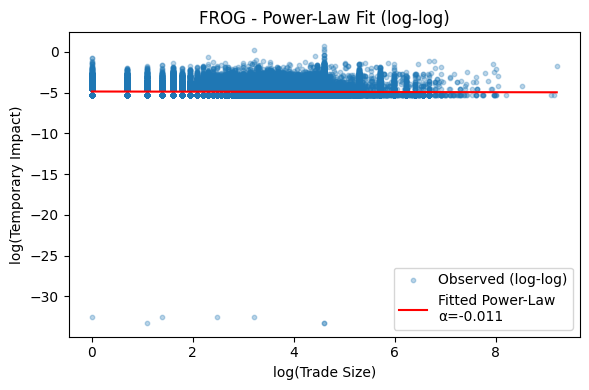

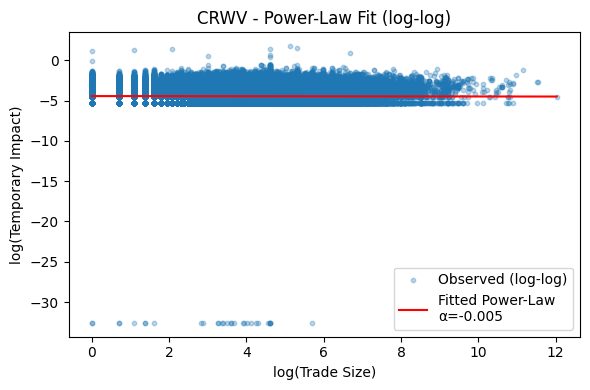

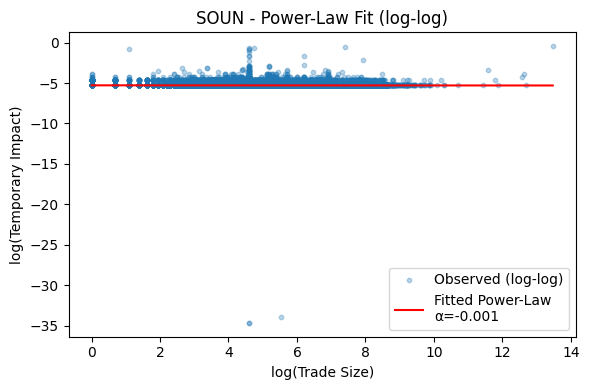

In [47]:
plot_power_law_fit(frog_df, 'FROG')
plot_power_law_fit(crwv_df, 'CRWV')
plot_power_law_fit(soun_df, 'SOUN')

## Modeling Temporary Market Impact: Beyond Linear Specifications

Previous analysis showed that simple linear or power-law models, which express temporary market impact g_t(x) as a function of trade size alone, fail to capture meaningful variation in impact for our tickers. The near-zero R^2 scores and very low curvature parameters suggest that trade size alone is an insufficient predictor.

This motivates a more flexible modeling approach incorporating additional market microstructure features that could drive temporary impact. We hypothesize that factors such as order book imbalance, bid-ask spread, trade direction, and liquidity dynamics play crucial roles.

In this section, we engineer relevant features from the order book and trade data and fit a Random Forest regression model to predict the temporary impact. This method can capture nonlinear relationships and feature interactions without assuming a predefined functional form.

We then analyze feature importance to gain insights into which variables most influence the temporary impact. Given the limited dataset (only 3 tickers), this exploratory modeling aims to highlight promising directions rather than definitive conclusions.

In [50]:
def prepare_features(df):
    """
    Create features relevant to temporary market impact modeling.
    Features include:
    - Trade size (size)
    - Mid-price (average of best bid and ask)
    - Bid-ask spread
    - Order book imbalance at top level
    - Trade side encoded as binary (buy=1, sell=0)
    Computes signed temporary impact as target variable.
    """
    df = df.copy()
    
    df['mid_price'] = (df['bid_px_00'] + df['ask_px_00']) / 2
    df['spread'] = df['ask_px_00'] - df['bid_px_00']
    df['imbalance'] = (df['bid_sz_00'] - df['ask_sz_00']) / (df['bid_sz_00'] + df['ask_sz_00'] + 1e-9)
    df['side_enc'] = df['side'].map({'B': 1, 'S': 0})
    
    df['impact'] = (df['price'] - df['mid_price']) * (2*df['side_enc'] - 1)
    
    df = df.dropna(subset=['impact', 'size', 'spread', 'imbalance', 'side_enc'])
    
    feature_cols = ['size', 'spread', 'imbalance', 'side_enc']
    X = df[feature_cols]
    y = df['impact']
    
    return X, y

def train_impact_model(X, y):
    """
    Train a Random Forest regression model to predict temporary impact.
    Splits data into train and test sets, fits the model, and reports performance metrics.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print(f"Test R^2: {r2:.4f}")
    print(f"Test MSE: {mse:.6f}")
    
    return model, X_test, y_test, y_pred

In [51]:
# Prepare features and train models for all files
X_frog, y_frog = prepare_features(frog_1min)
model_frog, X_test_frog, y_test_frog, y_pred_frog = train_impact_model(X_frog, y_frog)

X_crwv, y_crwv = prepare_features(crwv_1min)
model_crwv, X_test_crwv, y_test_crwv, y_pred_crwv = train_impact_model(X_crwv, y_crwv)

X_soun, y_soun = prepare_features(soun_1min)
model_soun, X_test_soun, y_test_soun, y_pred_soun = train_impact_model(X_soun, y_soun)

Test R^2: 0.5537
Test MSE: 0.006534
Test R^2: -0.0420
Test MSE: 0.000193
Test R^2: -0.0420
Test MSE: 0.000193


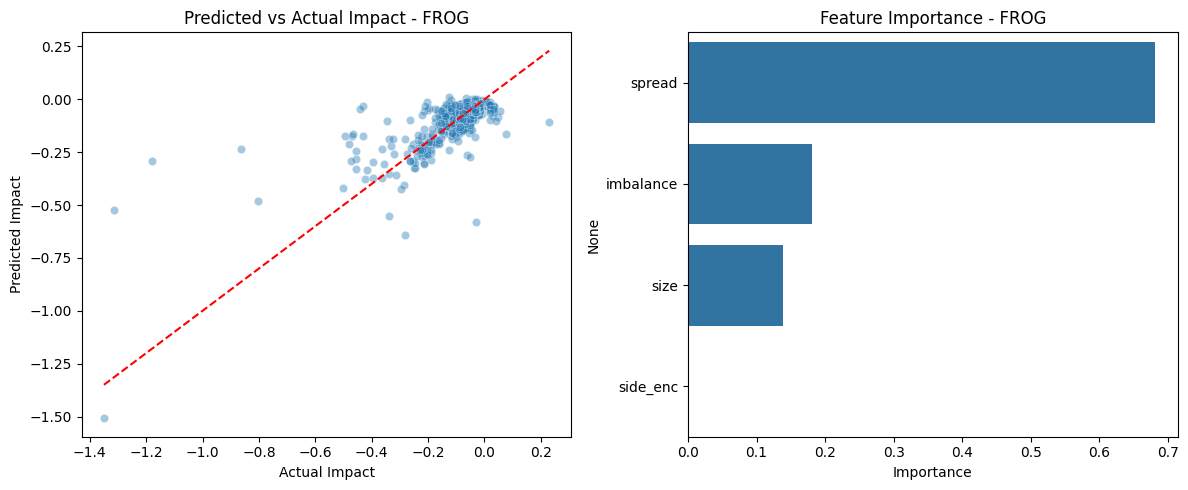

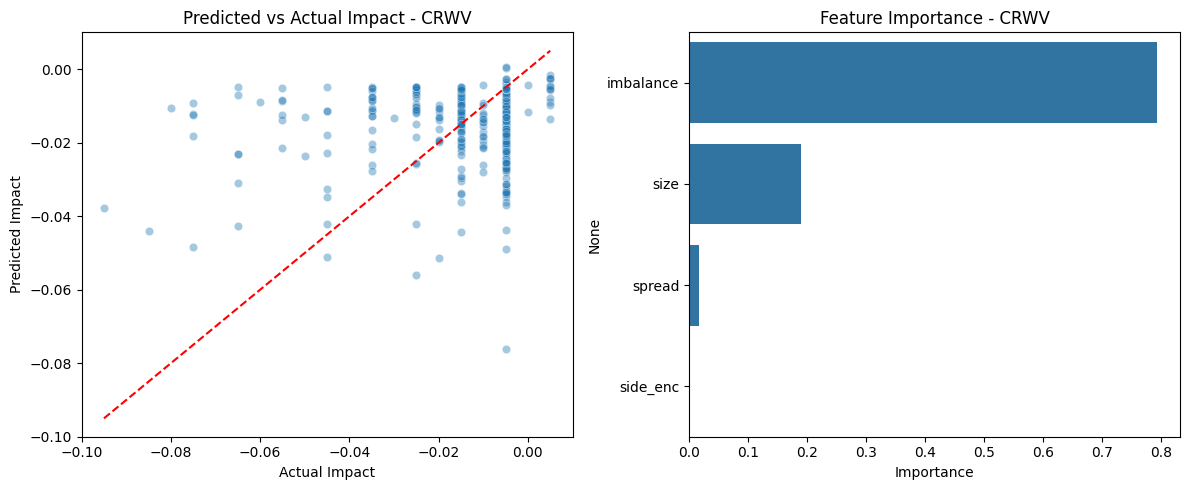

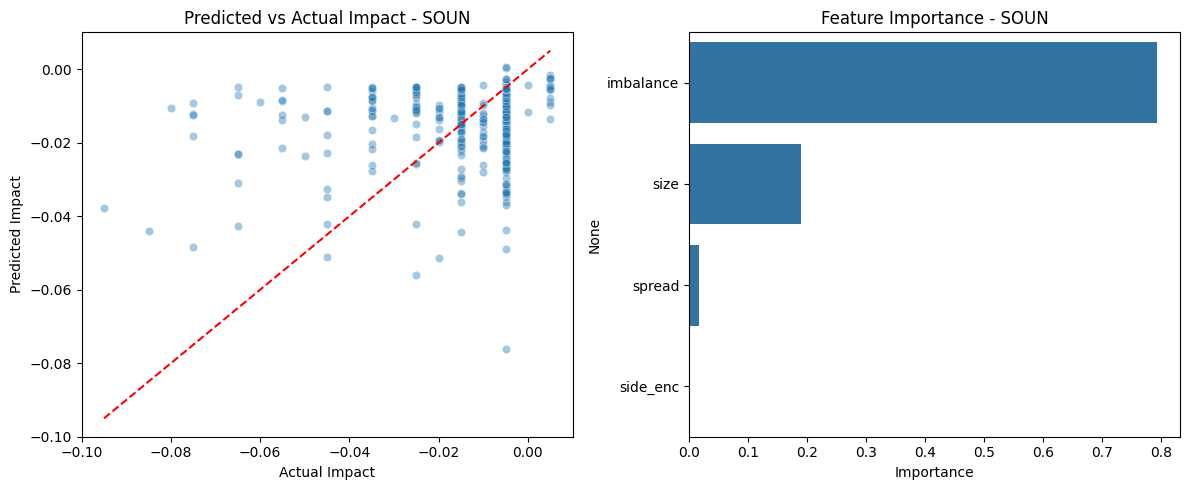

In [52]:
def plot_performance_and_importance(model, X_test, y_test, y_pred, ticker_name):
    plt.figure(figsize=(12,5))

    # Predicted vs Actual
    plt.subplot(1,2,1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Impact")
    plt.ylabel("Predicted Impact")
    plt.title(f"Predicted vs Actual Impact - {ticker_name}")

    # Feature Importance
    plt.subplot(1,2,2)
    importances = model.feature_importances_
    features = X_test.columns
    sorted_idx = importances.argsort()[::-1]
    sns.barplot(x=importances[sorted_idx], y=features[sorted_idx])
    plt.title(f"Feature Importance - {ticker_name}")
    plt.xlabel("Importance")

    plt.tight_layout()
    plt.show()

# Plot for all tickers
plot_performance_and_importance(model_frog, X_test_frog, y_test_frog, y_pred_frog, 'FROG')
plot_performance_and_importance(model_crwv, X_test_crwv, y_test_crwv, y_pred_crwv, 'CRWV')
plot_performance_and_importance(model_soun, X_test_soun, y_test_soun, y_pred_soun, 'SOUN')


**Inference**

The model works best for FROG, with an R² of about 0.55. This means it explains more than half of the variation in temporary impact. For CRWV and SOUN, the R² is negative, so the model does not predict well for these tickers. The MSE values also show that the errors are higher for FROG and lower but less meaningful for CRWV and SOUN.

This suggests that the model captures some patterns in FROG but fails to generalize to the other two tickers. Temporary impact is likely affected by other factors not captured by our features.

The plots of predicted versus actual values support this. FROG shows better alignment, while CRWV and SOUN have more spread out predictions. Feature importance plots also highlight which features matter most.

In summary, temporary impact is complex. Simple models may work for some stocks but not all. More advanced or tailored models may be needed.